In [269]:
import numpy as np
import pandas as pd

### Search recall

In [515]:
df = pd.read_csv('../data/results/eval_gpt-4.csv')

#df = pd.read_csv('eval_md.csv')
df = df[df["term"] == "min_lot_size"]

In [516]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 761 entries, 0 to 760
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   town                     761 non-null    object 
 1   district                 761 non-null    object 
 2   term                     761 non-null    object 
 3   confidence               761 non-null    float64
 4   expected                 578 non-null    object 
 5   expected_extended        468 non-null    object 
 6   actual                   353 non-null    object 
 7   correct_page_searched    761 non-null    int64  
 8   correct_page_extracted   761 non-null    int64  
 9   gt_page                  761 non-null    object 
 10  searched_pages           761 non-null    object 
 11  searched_pages_expanded  761 non-null    object 
 12  extracted_pages          761 non-null    object 
 13  actual_normalized        323 non-null    float64
 14  expected_normalized      5

In [517]:
df.groupby(['town', 'district']).ngroups

216

In [520]:
# df["correct_page_searched"] = df["correct_page_searched"].astype("int64")
# df["correct_page_extracted"] = df["correct_page_extracted"].astype("int64")
sdf = df.groupby(by=['town', 'district']).agg({"correct_page_searched": "sum"}).reset_index()

In [521]:
sdf["correct_page_searched"].value_counts()

1     139
0      28
2      28
4      11
3       8
5       1
13      1
Name: correct_page_searched, dtype: int64

In [522]:
sdf["correct"] = sdf["correct_page_searched"].apply(lambda x: 1 if x > 0 else 0)

In [523]:
recall = sdf["correct"].sum() / sdf.shape[0]
print("recall =", recall)

recall = 0.8703703703703703


In [277]:
incorrect_search = sdf[sdf["correct"] == 0]["town"].values.tolist()

In [278]:
len(incorrect_search)

10

In [279]:
df[df["town"].isin(incorrect_search)]

,town,district,term,expected,actual,correct_page_searched,correct_page_extracted,gt_page,searched_pages,searched_pages_expanded,extracted_pages,actual_normalized,expected_normalized,correct_answer
501,andover,Andover Lake,min_unit_size,500,NaN,0,0,{41},{96},"{96, 97, 95}",set(),NaN,500.0,False
502,andover,Andover Lake,min_unit_size,500,NaN,0,0,{41},{28},"{27, 28, 29, 30, 31}",set(),NaN,500.0,False
503,andover,Andover Lake,min_unit_size,500,NaN,0,0,{41},{189},"{192, 188, 189, 190, 191}",set(),NaN,500.0,False
504,ashford,Technology Development,min_unit_size,900,NaN,0,0,{29},{47},"{48, 49, 46, 47}",set(),NaN,900.0,False
518,east-windsor,Agriculture/Residential 1,min_unit_size,1248,NaN,0,0,{39},{36},"{35, 36}",set(),NaN,1248.0,False
519,east-windsor,Agriculture/Residential 1,min_unit_size,1248,NaN,0,0,{39},{81},"{80, 81, 82}",set(),NaN,1248.0,False
550,manchester,Rural Residence,min_unit_size,1100,NaN,0,0,{57},{49},"{48, 49, 50, 51}",set(),NaN,1100.0,False
551,manchester,Rural Residence,min_unit_size,1100,NaN,0,0,{57},{331},"{330, 331, 332, 333, 334, 335, 336, 337, 338, ...",set(),NaN,1100.0,False
556,morris,Commercial B,min_unit_size,"1000, 700, 600",NaN,0,0,{45},{41},"{40, 41, 42, 43, 44}",set(),NaN,1000.0,False
557,morris,Commercial B,min_unit_size,"1000, 700, 600",NaN,0,0,{45},{41},"{40, 41, 42, 43, 44}",set(),NaN,700.0,False


### Answer accuracy

In [623]:
gt = pd.read_csv('../data/ground_truth.csv')

In [642]:
gt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 229 entries, 0 to 228
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   town                   229 non-null    object
 1   district_abb           229 non-null    object
 2   district               229 non-null    object
 3   district_page          186 non-null    object
 4   min_lot_size_gt_orig   136 non-null    object
 5   min_lot_size_gt        170 non-null    object
 6   min_lot_size_page_gt   179 non-null    object
 7   min_unit_size_gt_orig  61 non-null     object
 8   min_unit_size_gt       38 non-null     object
 9   min_unit_size_page_gt  58 non-null     object
 10  review                 103 non-null    object
 11  notes                  122 non-null    object
dtypes: object(12)
memory usage: 21.6+ KB


In [624]:
print("default ngroups", gt.groupby(['town', 'district']).ngroups)
print("default ntowns", gt['town'].nunique())

default ngroups 229
default ntowns 176


In [625]:
gt_towns = list(gt['town'].unique())

In [626]:
df = pd.read_csv('../data/results/eval_gpt-4.csv')
term = 'min_unit_size'
df = df[df['term'] == term]

In [627]:
print("default ngroups", df.groupby(['town', 'district']).ngroups)
print("default ntowns", df['town'].nunique())

default ngroups 196
default ntowns 156


In [628]:
df_towns = list(df['town'].unique())

In [679]:
#gt[~gt['town'].isin(df_towns)]

In [630]:
adf = df.groupby(by=['town', 'district']).agg({"correct_answer": "sum"}).reset_index()

In [631]:
adf['correct_answer'].value_counts()

1    56
2    46
3    33
0    27
4    24
5     7
6     3
Name: correct_answer, dtype: int64

In [632]:
adf["correct"] = adf["correct_answer"].apply(lambda x: 1 if x > 0 else 0)
acc = adf["correct"].sum() / adf.shape[0]
print("accuracy =", acc)

accuracy = 0.8622448979591837


In [633]:
incorrect_answer = adf[adf["correct"] == 0]["town"].values.tolist()

In [634]:
df_inc = df[df["town"].isin(incorrect_answer)]

In [635]:
df_inc[df_inc["correct_page_searched"] == 1].shape

(39, 16)

In [662]:
df_cond_wrong = df_inc[(df_inc["correct_answer"] == False) & (df_inc["correct_page_searched"] == 1)] # search is right but answer is wrong
df_wrong = df_inc[(df_inc["correct_answer"] == False) & (df_inc["correct_page_searched"] == 0)] # search is wrong and answer is wrong

In [678]:
df_wrong_both = pd.concat([df_cond_wrong, df_wrong])
print("ngroups", df_wrong_both.groupby(['town', 'district']).ngroups)

ngroups 31


In [675]:
df_wrong

,town,district,term,confidence,expected,expected_extended,actual,correct_page_searched,correct_page_extracted,gt_page,searched_pages,searched_pages_expanded,extracted_pages,actual_normalized,expected_normalized,correct_answer
765,cornwall,Cornwall Plains,min_unit_size,0.50,NaN,NaN,"20,000 sq ft",0,0,set(),{25},"{24, 25, 26}",{25},20000.0,NaN,False
797,barkhamsted,Restricted Business,min_unit_size,1.00,NaN,NaN,750 sq ft,0,0,set(),{21},"{20, 21}",{20},750.0,NaN,False
799,east-granby,Planned Residential,min_unit_size,0.50,1400,1400,"120,000 sq ft",0,0,{35},{41},"{40, 41, 42, 43}",{41},120000.0,1400.0,False
800,east-granby,Planned Residential,min_unit_size,0.00,1400,1400,NaN,0,0,{35},{18},"{17, 18, 19, 20}",set(),NaN,1400.0,False
835,branford,Residence R-3,min_unit_size,1.00,NaN,NaN,"15,000 sq ft",0,0,set(),{41},"{40, 41}",{40},15000.0,NaN,False
837,ashford,Technology Development,min_unit_size,0.00,900,900,NaN,0,0,{29},{47},"{48, 49, 46, 47}",set(),NaN,900.0,False
854,barkhamsted,General Business,min_unit_size,0.50,NaN,NaN,750 sq ft,0,0,set(),{21},"{20, 21}",{20},750.0,NaN,False
882,branford,Multifamily Residence,min_unit_size,1.00,NaN,NaN,"7,260 sq ft",0,0,set(),{41},"{40, 41}",{40},7260.0,NaN,False
900,east-hartford,Business 2,min_unit_size,0.00,NaN,"1,000 (for a 1 floor dwelling); 1,200 (for a 2 floor dwelling)",no min unit size found,0,0,set(),{112},"{112, 113, 114, 111}","{112, 113, 114, 111}",NaN,NaN,False
909,east-haven,Light Industrial 3,min_unit_size,0.50,900,NaN,450 sq ft,0,0,{67},{158},"{160, 157, 158, 159}",{157},450.0,900.0,False


In [574]:
from datasets import load_dataset
dataset = load_dataset("xyzNLP/nza-ct-zoning-codes-text")

Using custom data configuration xyzNLP--nza-ct-zoning-codes-text-579051b4b18688cb


Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating test split:   0%|          | 0/9817 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/22088 [00:00<?, ? examples/s]

Dataset parquet downloaded and prepared to /Users/eeshakhanna/.cache/huggingface/datasets/xyzNLP___parquet/xyzNLP--nza-ct-zoning-codes-text-579051b4b18688cb/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [575]:
dataset.set_format("pandas")
df_train = dataset['train'][:]
df_test = dataset['test'][:]

In [588]:
pd.set_option('display.max_colwidth', None)

In [659]:
text = df_train[(df_train['Town'] == 'east-granby') & (df_train['Page'] == 36)]['Text'].to_string(index=False)

In [660]:
import textwrap

print(textwrap.fill(text, width=100))  # Change 'width' to the number of characters you want in a line

Section IV -- RESIDENTIAL & AGRICULTURAL ZONES\n6.\nArea & Bulk Requirements\n7.\nLiving Area
Requirements\nMinimum Total Living Area\n1,400 square feet\n8.\nOther Requirements\nOnce approved by
the Commission, dwelling locations shall remain as shown on the PRD\nsubdivision map. Modifications
to dwellings or dwelling locations may be approved:\nby the Zoning Enforcement Officer provided that
such modifications comply with the yard\nrequirements of the R-40 zone, or\nby the Commission in all
other cases.\nD.\nELDERLY HOUSING ZONE\n1.\nPurpose\nThe purpose of this Regulation is to provide
housing suited to the unique needs of elderly\npersons that is integrated into the community and
that will help the elderly maintain their\nindependence while providing the physical and financial
safeguards they require.\n2.\nGrowth Management Plan\nMulti-family dwelling units shall not exceed
33 percent of the single-family housing stock within\nEast Granby. For the purposes of this section,
a multi-f

### Estimating performance plot

df_cond_wrong.iloc[15:]

In [470]:
df = pd.read_csv('../data/results/eval_gpt-4.csv')
term = 'min_lot_size'
df = df[df['term'] == term]

In [556]:
# recall 
df_recall = df.groupby(by=['town', 'district']).agg({"correct_page_searched": "sum"}).reset_index()
df_recall["correct_search"] = df_recall["correct_page_searched"].apply(lambda x: 1 if x > 0 else 0)

# acc 
df_acc = df.groupby(by=['town', 'district']).agg({"correct_answer": "sum"}).reset_index()
df_acc["correct_acc"] = df_acc["correct_answer"].apply(lambda x: 1 if x > 0 else 0)

In [557]:
df_sample = df_recall.copy()
df_sample["correct_acc"] = df_acc["correct_acc"]

In [568]:
n_all = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120]

recalls = []
accs = []

avg_over = 10

for n in n_all:
    total_recall = 0
    total_accs = 0
    for i in range(avg_over):
        sample = df_sample.sample(n=n, replace=False)
        sample_recall = sample['correct_search'].sum() / n
        sample_acc = sample['correct_acc'].sum() / n
        total_recall += sample_recall
        total_accs += sample_acc
    recalls.append(total_recall/avg_over)
    accs.append(total_accs/avg_over)

(0.0, 1.0)

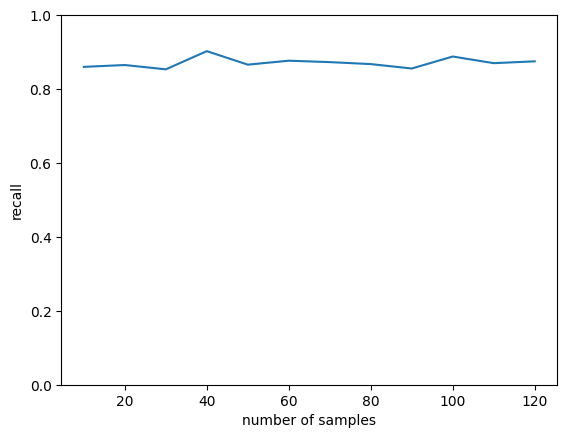

In [569]:
import matplotlib.pyplot as plt
plt.plot(n_all, recalls)
plt.xlabel('number of samples')
plt.ylabel('recall')
plt.ylim(0, 1)

(0.0, 1.0)

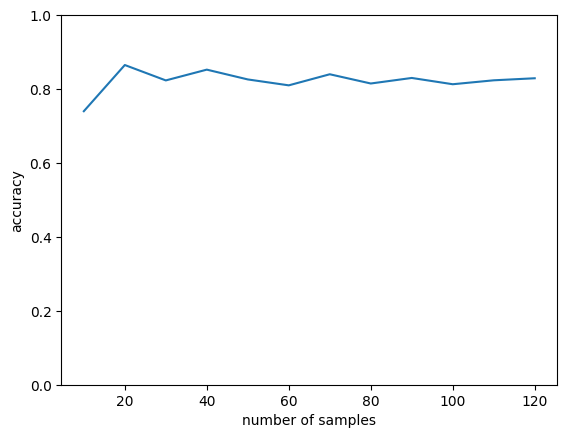

In [570]:
import matplotlib.pyplot as plt
plt.plot(n_all, accs)
plt.xlabel('number of samples')
plt.ylabel('accuracy')
plt.ylim(0, 1)